# 1. Basic imports and settings

In [1]:
import os
import sys
import argparse
sys.path.append("/mnt/8t/jjr/Structural-DPP-IV")

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# from model import StructuralDPPIV
from config import load_config
from config.load_constant import constant
from data import StructuralEncode
from data import Encode
from util import util_draw

config_dict = load_config.load_default_args_dict("StructuralDPPIV")
config_dict['max_epochs'] = 150
config_dict['gpus'] = [3]  # using which GPU to train
config_dict['batch_size'] = 32
config_dict['lr'] = 0.000005
config_dict['model'] = 'StructuralDPPIV'
config_dict['log_dir'] = constant['path_log']
config_dict['max_seq_len'] = 90
args = argparse.Namespace(**config_dict)

class StructuralDPPIV(nn.Module):
    def __init__(self, config):
        super(StructuralDPPIV, self).__init__()
        self.StructEncodeModule = Structural(config)
        self.TextCNN = TextCNN()

        self.classification = nn.Sequential(
            nn.Linear(1024, 64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.Ws = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)
        self.Wh = nn.Parameter(torch.randn(1, 1024).cuda(), requires_grad=True)
        self.TextCNN_Only  = False
        self.StructuralEncodingOnly  = False

    def forward(self, x):
        TextCNN_Only = self.TextCNN_Only
        StructuralEncodingOnly = self.StructuralEncodingOnly
        assert not (TextCNN_Only and StructuralEncodingOnly)
        if not TextCNN_Only and not StructuralEncodingOnly:
            TextCNNEncode = self.TextCNN(x[0])
            StructedEncode = self.StructEncodeModule(x[1])
            newEncode = TextCNNEncode * StructedEncode
            FinalRepresentation = newEncode
            for i in range(len(self.classification)):
                FinalRepresentation = self.classification[i](FinalRepresentation)
                if i == 2:
                    output_representation = FinalRepresentation
            output = self.classification(newEncode)
            # return output
        elif TextCNN_Only:
            TextCNNEncode = self.TextCNN(x[0])
            FinalRepresentation = TextCNNEncode
            for i in range(len(self.classification)):
                FinalRepresentation = self.classification[i](FinalRepresentation)
                if i == 2:
                    output_representation = FinalRepresentation
            output = self.classification(TextCNNEncode)
            # return output
        elif StructuralEncodingOnly:
            StructedEncode = self.StructEncodeModule(x[1])
            FinalRepresentation = StructedEncode
            for i in range(len(self.classification)):
                FinalRepresentation = self.classification[i](FinalRepresentation)
                if i == 2:
                    output_representation = FinalRepresentation
            output = self.classification(StructedEncode)
        # return output, FinalRepresentation
        return FinalRepresentation, output_representation


class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.visualization = False
        vocab_size = 24
        dim_embedding = 100
        print(f"[INFO] using CNN config of {dataset_name}")
        # filter_sizes = [1, 2, 4, 8, 16, 24, 32, 48, 64]
        filter_sizes = [1, 2]
        filter_num = 90
        self.embedding = nn.Embedding(vocab_size, dim_embedding)
        self.convs = nn.ModuleList(
            [nn.Conv2d(1, filter_num, (fsz, dim_embedding)) for fsz in filter_sizes])
        self.linear = nn.Linear(filter_num * len(filter_sizes), 1024)

    def forward(self, x):
        # print("\nx = \n", x)
        x = self.embedding(x)
        x = x.view(x.size(0), 1, x.size(1), -1)
        x = [F.relu(conv(x)) for conv in self.convs]

        x = [F.max_pool2d(input=x_item, kernel_size=(x_item.size(2), x_item.size(3))) for x_item in x]
        x = [x_item.view(x_item.size(0), -1) for x_item in x]
        embedding = torch.cat(x, 1)
        embedding = self.linear(embedding)

        return embedding


class Structural(nn.Module):
    def __init__(self, config):
        super(Structural, self).__init__()
        self.config = config
        self.inpuchannel = [32, 32, 64]
        global dataset_name
        dataset_name = 'DPP-IV'
        print(f"[INFO] using Structural config of {dataset_name}")
        self.embedding_dim = 21
        global max_seq_len
        max_seq_len = config.max_seq_len
        self.conv = torch.nn.Conv2d(self.embedding_dim, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        # self.conv = torch.nn.Conv2d(19, self.inpuchannel[0], (3, 3), stride=1, padding='same')
        self.resBlock1 = resBlock(self.inpuchannel[0], self.inpuchannel[1])
        self.resBlock2 = resBlock(self.inpuchannel[1], self.inpuchannel[2], increDimen=True)
        self.linear = nn.Linear(23552, 1024)

    def forward(self, graph):
        # 90 is the max length of sequence, 15 is the number of amino acid, 21 is the number of channel
        graph = graph.cuda()  # (batchSize, 90, 15, 21)
        graph = graph.transpose(2, 3)  # (batchSize, 90, 21, 15)
        graph = graph.transpose(1, 2)   # (batchSize, 21, 90, 15)
        representation = self.conv(graph) # (batchSize, 32, 90, 15)
        representation = self.resBlock1(representation) # (batchSize, 32, 90, 15)
        representation = self.resBlock2(representation) # (batchSize, 64, 46, 8)
        representation = representation.flatten(start_dim=1) # (batchSize, 23552)
        representation = self.linear(representation) # (batchSize, 1024)
        return representation


class resBlock(nn.Module):
    def __init__(self, inputchannel, outputchannel, increDimen=False):
        super(resBlock, self).__init__()
        self.increDimen = increDimen
        self.inputchannel = inputchannel
        self.outputchannel = outputchannel
        padding_dim1 = 2 if max_seq_len % 2 == 0 else 1
        self.conv = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=(2, 2), padding=(padding_dim1, 1))
        self.conv1 = torch.nn.Conv2d(inputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm1 = nn.BatchNorm2d(inputchannel, affine=True)
        self.conv2 = torch.nn.Conv2d(outputchannel, outputchannel, (3, 3), stride=1, padding='same')
        self.batchnorm2 = nn.BatchNorm2d(outputchannel, affine=True)

    def forward(self, feature):
        original = feature

        if self.increDimen:
            feature = F.max_pool2d(input=feature, kernel_size=(2, 2), padding=1)
            original = self.conv(original)
        feature = self.batchnorm1(feature)
        feature = F.relu(feature)
        feature = self.conv1(feature)
        feature = self.batchnorm2(feature)
        feature = F.relu(feature)
        feature = self.conv2(feature)
        feature = feature + original
        return feature


def load_params(model, param_path):
    pretrained_dict = torch.load(param_path)['state_dict']
    # print(pretrained_dict.keys())
    new_model_dict = model.state_dict()
    # print(new_model_dict.keys())
    pretrained_dict = {'.'.join(k.split('.')[1:]): v for k, v in pretrained_dict.items() if '.'.join(k.split('.')[1:]) in new_model_dict}
    # pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if k[6:] in new_model_dict}
    # print(pretrained_dict.keys())
    new_model_dict.update(pretrained_dict)
    model.load_state_dict(new_model_dict)


def get_one_sequence_code(sequence = 'YPFPGPIP'):
    # sequence = 'YPFPGPIP'
    Channel = StructuralEncode.convert_to_graph_channel(sequence)
    Structure_data = StructuralEncode.convert_to_graph_channel_returning_maxSeqLenx15xfn(Channel, cubeBiased=False,
                                                                 maxSeqLen=90, cubeBias=False,
                                                                 right_align=False)
    tensor_Structure_data = torch.tensor(Structure_data).cuda()
    tensor_Structure_data = torch.unsqueeze(tensor_Structure_data, 0)
    # tensor_Structure_data = tensor_Structure_data.transpose(2, 3)  # (batchSize, 90, 21, 15)
    # tensor_Structure_data = tensor_Structure_data.transpose(1, 2)   # (batchSize, 21, 90, 15)

    sequence_data_process = Encode.codePeptides([sequence])
    sequence_data_length = len(sequence_data_process[0])
    sequence_data_padding = np.pad(sequence_data_process[0], (0, 90 - sequence_data_length), 'constant', constant_values=0)
    sequence_data = torch.tensor(np.array([sequence_data_padding])).cuda()

    # print(sequence_data)
    return [sequence_data, tensor_Structure_data]


/mnt/8t/jjr/Structural-DPP-IV


In [7]:

new_model = StructuralDPPIV(args).cuda()
new_model.eval()
# TextCNN_Only = True
TextCNN_Only = False
# StructuralEncodingOnly = True
StructuralEncodingOnly = False

if TextCNN_Only == False and StructuralEncodingOnly == False:
    load_params(new_model, '/mnt/8t/jjr/Structural-DPP-IV/main/log/StructuralDPPIV/version_3/checkpoints/epoch=73,step=2442,val_SE_epoch=0.95,val_SP_epoch=0.87,val_F1_epoch=0.91,val_AUC_epoch=1.00.ckpt')
elif StructuralEncodingOnly == True and TextCNN_Only == False:
    load_params(new_model, '/mnt/8t/jjr/Structural-DPP-IV/main/log/StructuralDPPIV/version_4/checkpoints/epoch=60,step=2013,val_SE_epoch=0.97,val_SP_epoch=0.81,val_F1_epoch=0.90,val_AUC_epoch=1.00.ckpt')
elif StructuralEncodingOnly == False and TextCNN_Only == True:
    load_params(new_model, '/mnt/8t/jjr/Structural-DPP-IV/main/log/StructuralDPPIV/version_5/checkpoints/epoch=129,step=4290,val_SE_epoch=0.95,val_SP_epoch=0.72,val_F1_epoch=0.85,val_AUC_epoch=1.00.ckpt')

new_model.StructuralEncodingOnly = StructuralEncodingOnly
new_model.TextCNN_Only = TextCNN_Only
new_model.eval()
print(new_model.TextCNN_Only)
print(new_model.StructuralEncodingOnly)

[INFO] using Structural config of DPP-IV
[INFO] using CNN config of DPP-IV
False
False


In [8]:
def load_tsv(filename, skip_head=True):
    sequences = []
    labels = []
    with open(filename, 'r') as file:
        if skip_head:
            next(file)
        for line in file:
            if line[-1] == '\n':
                line = line[:-1]
            list = line.split('\t')
            sequences.append(list[2])
            labels.append(int(list[1]))
    return sequences, labels

embedding_array = np.array([])
# embedding_array.resize(1,1024)
embedding_array.resize(1,64)
# print(embedding_array.shape)
pred_prob = []
label_pred = []
predict_true = 0

sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/test/test.tsv')
# sequences, labels = load_tsv('/mnt/8t/jjr/Structural-DPP-IV/data/DPP-IV/train/train.tsv')
from tqdm import tqdm
# predict sequence one by one
for index in tqdm(range(len(sequences))):
    # print("before success2:", config.learn_name)
    DATA = get_one_sequence_code(sequences[index])
    logits, embedding = new_model(DATA)
    # print(embedding.cpu().detach().numpy().shape)
    embedding_array = np.append(embedding_array, embedding.cpu().detach().numpy(), axis=0)
    # print(embedding_array.shape)

    pred_prob_all = F.softmax(logits, dim=1)  # predict probability [batch_size, class_num]
    pred_prob_positive = pred_prob_all[:, 1]  # note, it is very easy to make mistake
    pred_prob_sort = torch.max(pred_prob_all, 1)  # max probability in each sample [batch_size]
    pred_class = pred_prob_sort[1]  # where max probability site in each sample [batch_size]

    pred_prob = pred_prob + pred_prob_positive.tolist()
    label_pred = label_pred + pred_class.tolist()

acc = accuracy_score(labels, label_pred)
auc = roc_auc_score(labels, pred_prob)
f1 = f1_score(labels, label_pred)
se = recall_score(labels, label_pred)
sp = recall_score(labels, label_pred, pos_label=0)

print('acc:', acc)
print('auc:', auc)
print('f1:', f1)
print('se:', se)
print('sp:', sp)

import copy
embedding_array = embedding_array[1:]
if TextCNN_Only == False and StructuralEncodingOnly == False:
    Structural_DPP_IV_embedding = copy.copy(embedding_array)
elif StructuralEncodingOnly == True and TextCNN_Only == False:
    StructuralEncodingOnly_embedding = copy.copy(embedding_array)
elif StructuralEncodingOnly == False and TextCNN_Only == True:
    TextCNN_Only_embedding = copy.copy(embedding_array)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:03<00:00, 78.10it/s]

acc: 0.9097744360902256
auc: 0.9657414212222284
f1: 0.9130434782608695
se: 0.9473684210526315
sp: 0.8721804511278195


In [34]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import umap
plt.rcParams['savefig.dpi'] = 600  # 图片像素
plt.rcParams['figure.dpi'] = 300  # 分辨率

def visualize_t_SNE(title, data, labels, class_num):
    cmap = ListedColormap(['#C6E5A9', '#B795D9'])
    X_tsne = TSNE(n_components=2).fit_transform(data)  # [num_samples, n_components]
    font = {"color": "darkred", "size": 13, "family": "serif"}

    plt.figure()
    figure, ax = plt.subplots()
    ax.grid(False)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, alpha=0.6, cmap=cmap)
    plt.title(title, fontdict=font)

    cbar = plt.colorbar(ticks=range(class_num))
    # cbar.set_label(label='digit value', fontdict=font)
    plt.clim(0 - 0.5, class_num - 0.5)
    # plt.savefig('/mnt/8t/jjr/Structural-DPP-IV/experiments/plot_data/{}.svg'.format(title+'_t-SNE'))
    plt.show()

def visualize_PCA(title, data, labels, class_num):
    cmap = ListedColormap(['#C6E5A9', '#B795D9'])
    X_tsne = PCA(n_components=2).fit_transform(data)  # [num_samples, n_components]
    font = {"color": "darkred", "size": 13, "family": "serif"}

    plt.figure()
    figure, ax = plt.subplots()
    ax.grid(False)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, alpha=0.6, cmap=cmap)
    plt.title(title, fontdict=font)

    cbar = plt.colorbar(ticks=range(class_num))
    # cbar.set_label(label='digit value', fontdict=font)
    plt.clim(0 - 0.5, class_num - 0.5)
    plt.savefig('/mnt/8t/jjr/Structural-DPP-IV/experiments/plot_data/{}.svg'.format(title+'_PCA'))
    plt.show()

def visualize_Umap(title, data, labels, class_num):
    cmap = ListedColormap(['#C6E5A9', '#B795D9'])
    scaled_data = StandardScaler().fit_transform(data)
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(scaled_data)

    plt.figure()
    figure, ax = plt.subplots()
    ax.grid(False)
    sc = plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=labels, cmap=cmap, s=20
    )

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontdict={'weight': 'normal', 'size': 12})

    plt.clim(0 - 0.5, class_num - 0.5)
    cbar = plt.colorbar(sc, ticks=[i for i in range(class_num)])
    # cbar = plt.colorbar(sc, ticks=[0,1])
    cbar.ax.set_yticklabels(['pos', 'neg'], fontdict={'weight': 'normal', 'size': 14})  # horizontal colorbar
    # cbar.ax.set_yticklabels(label_list_name, fontdict={'weight': 'normal', 'size': 12})  # horizontal colorbar
    plt.savefig('/mnt/8t/jjr/Structural-DPP-IV/experiments/plot_data/{}.svg'.format(title+'_Umap'))
    plt.show()

<Figure size 1800x1200 with 0 Axes>

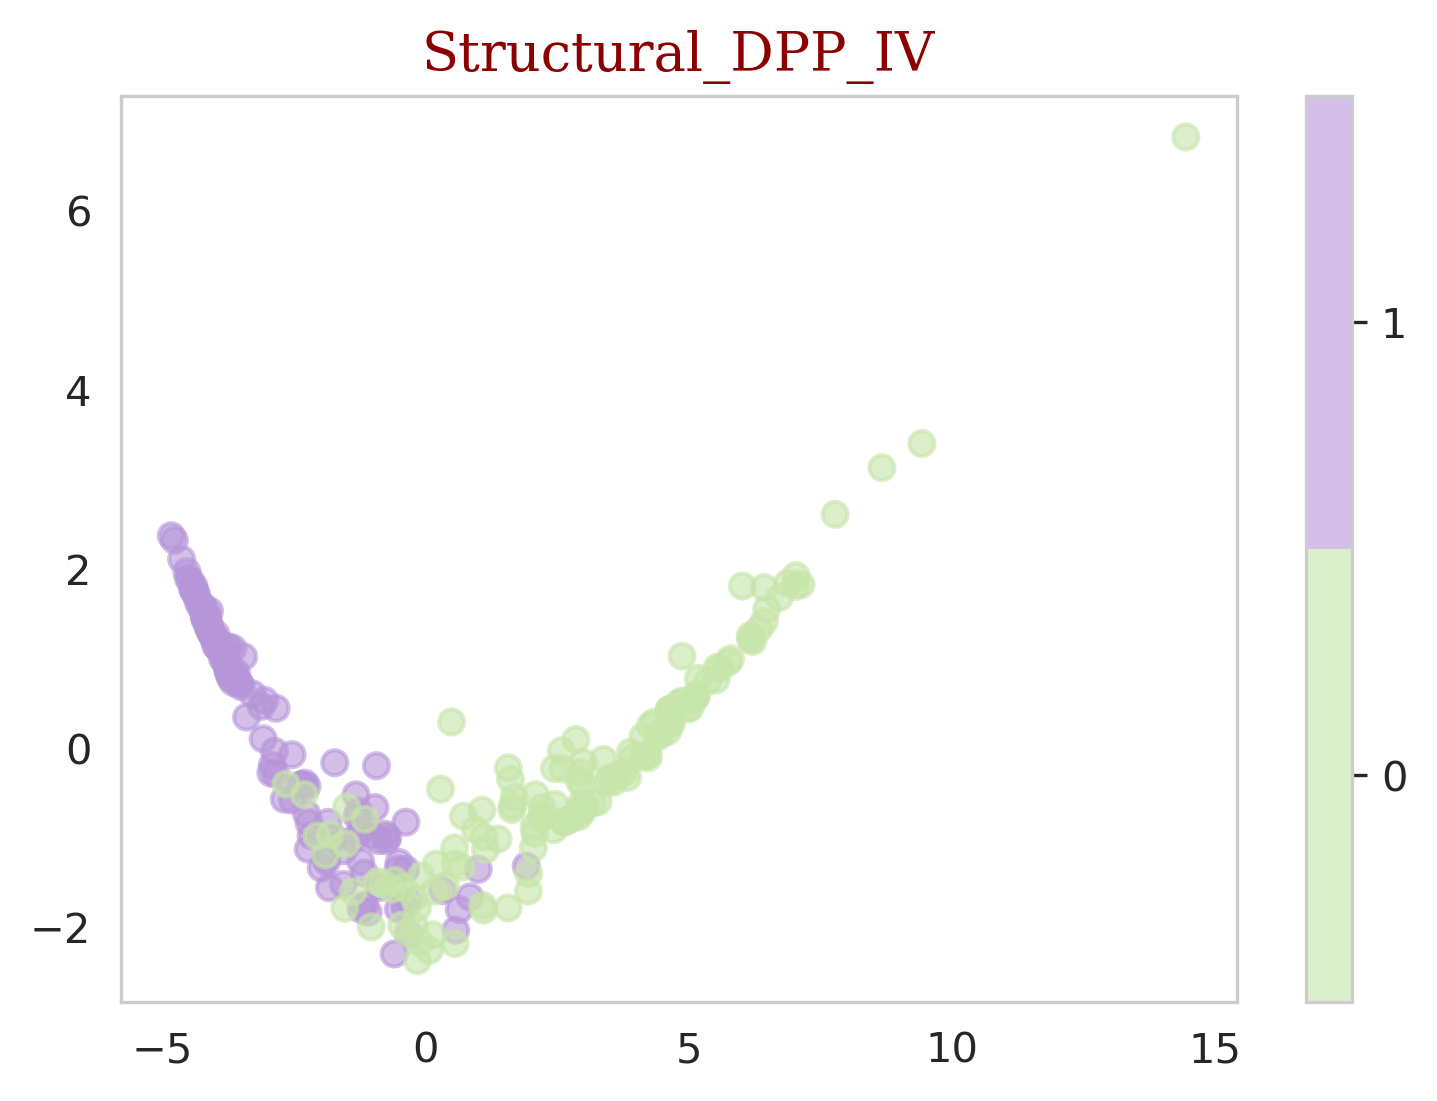

In [25]:
visualize_PCA("Structural_DPP_IV", Structural_DPP_IV_embedding, labels, 2)

<Figure size 1800x1200 with 0 Axes>

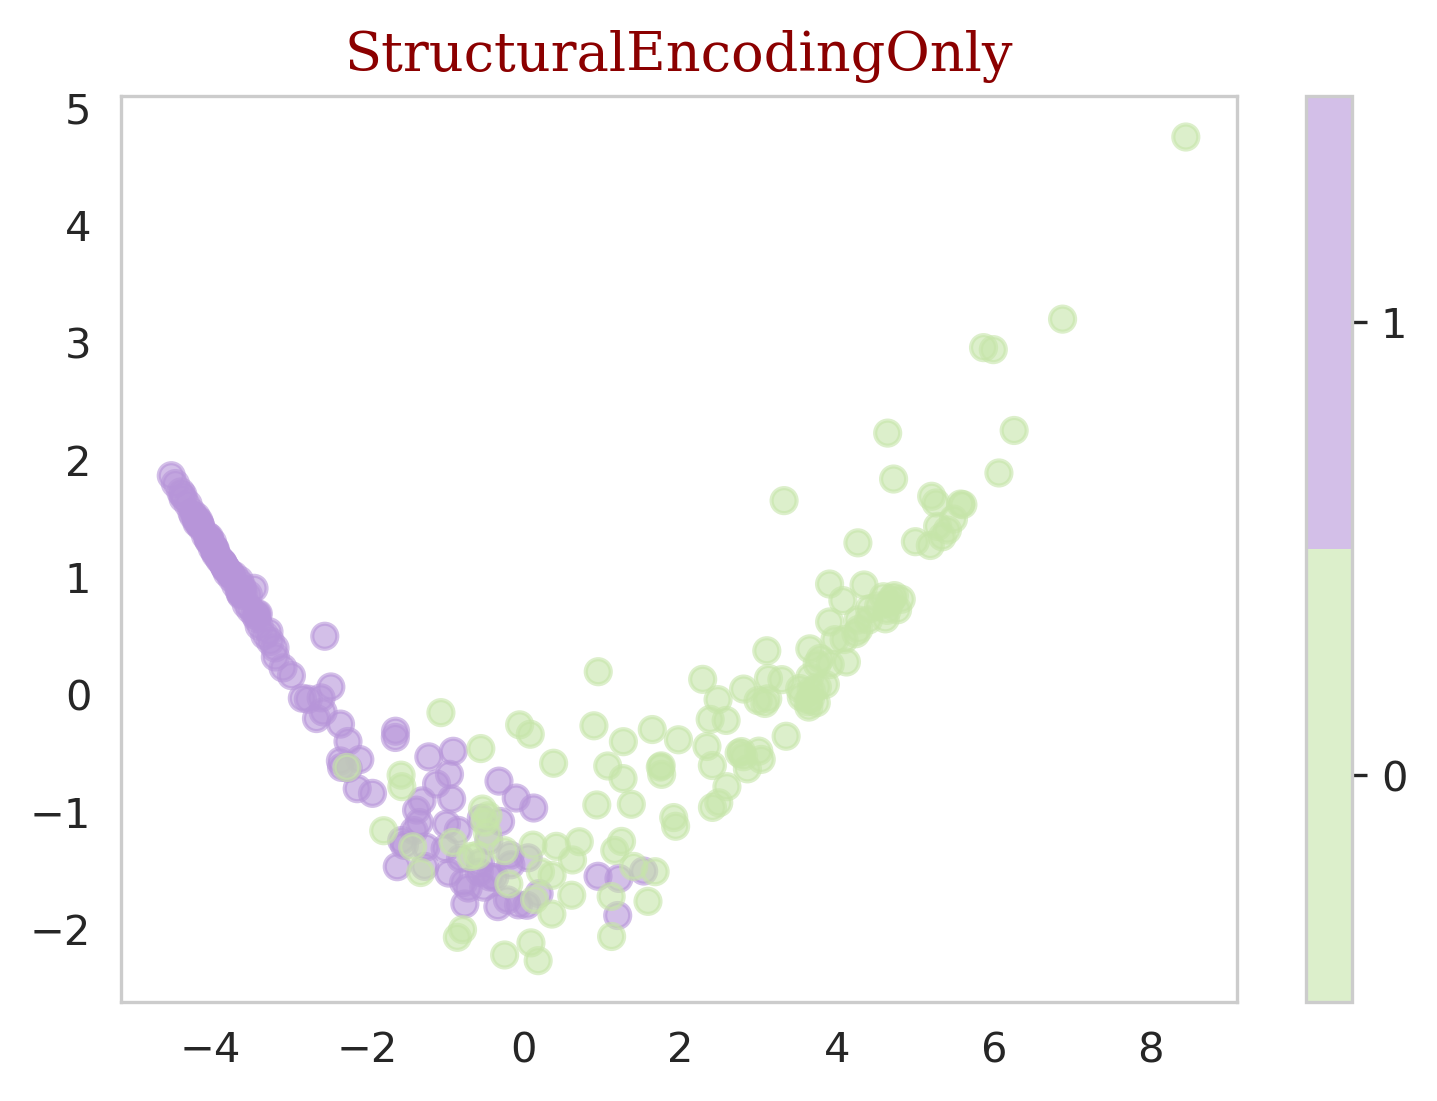

In [26]:
visualize_PCA("StructuralEncodingOnly", StructuralEncodingOnly_embedding, labels, 2)

<Figure size 1800x1200 with 0 Axes>

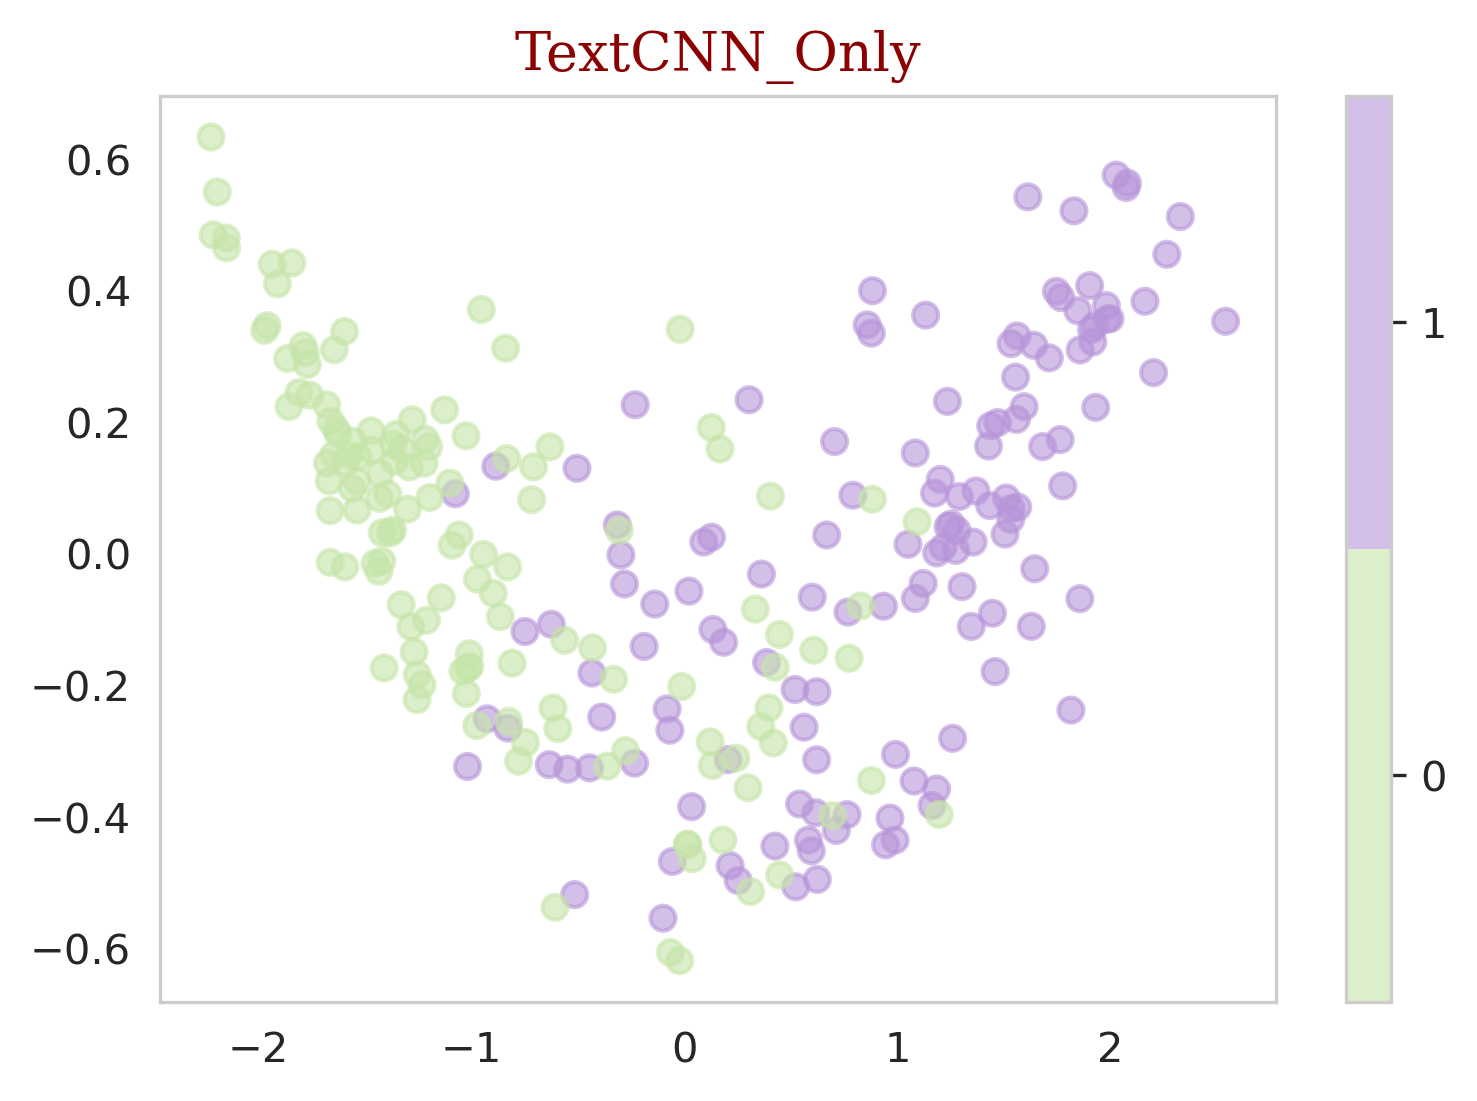

In [27]:
visualize_PCA("TextCNN_Only", TextCNN_Only_embedding, labels, 2)

/home/weilab/anaconda3/envs/jjr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/weilab/anaconda3/envs/jjr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 1800x1200 with 0 Axes>

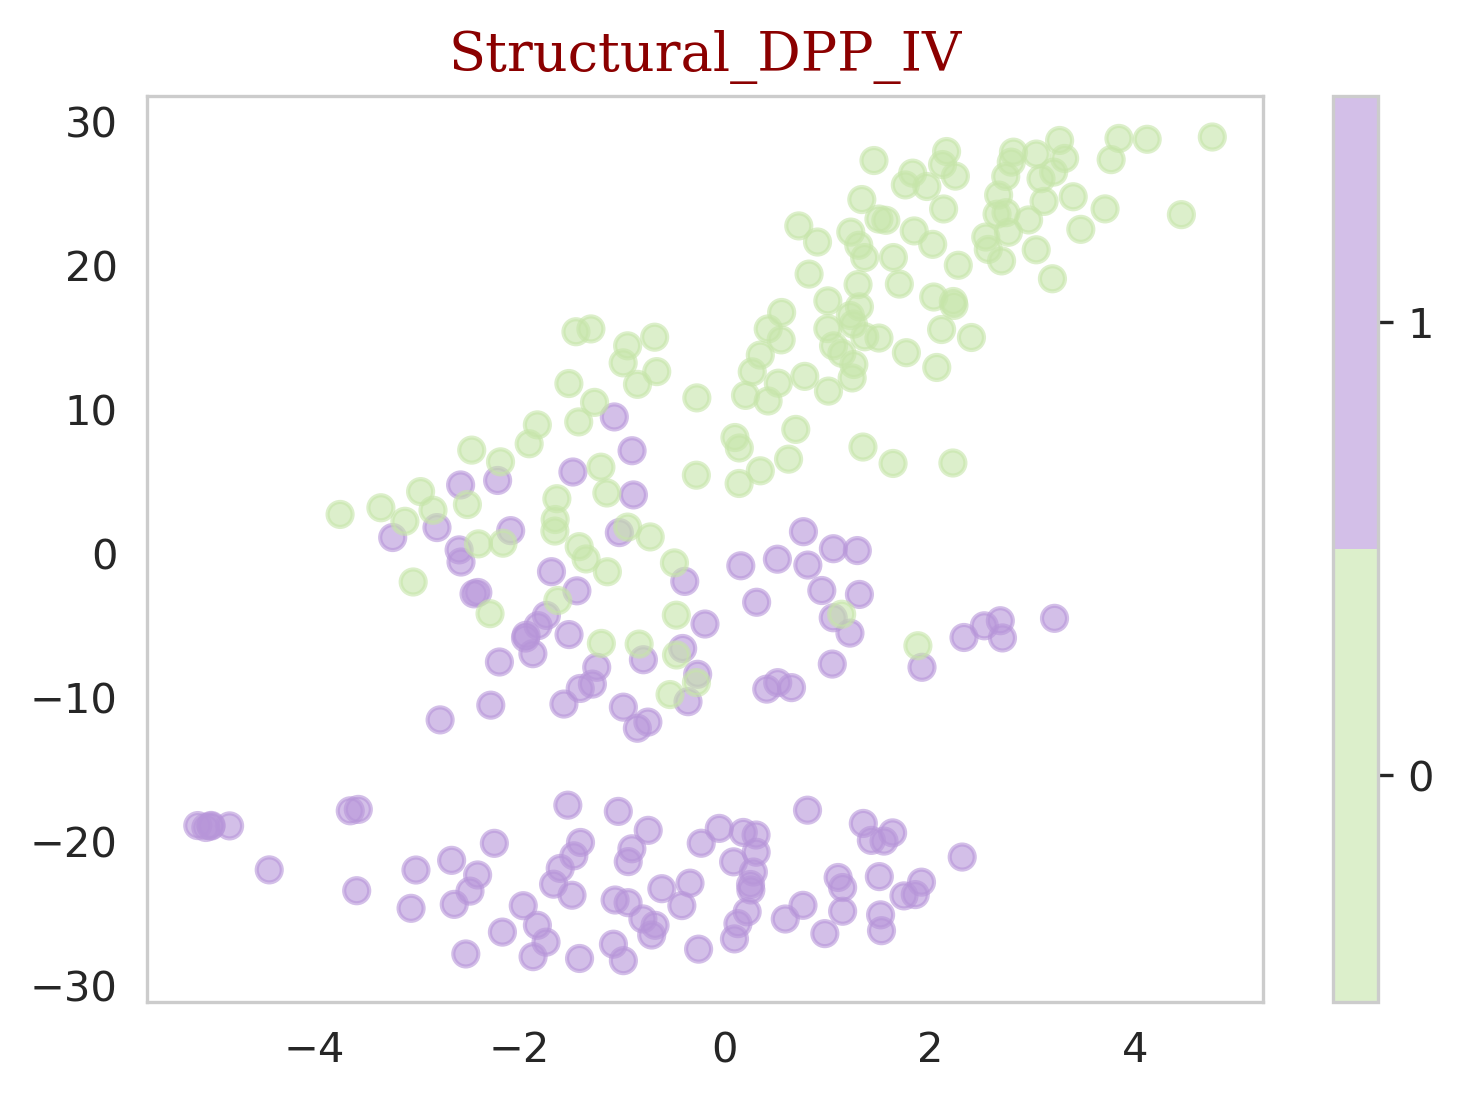

In [28]:
visualize_t_SNE("Structural_DPP_IV", Structural_DPP_IV_embedding, labels, 2)

/home/weilab/anaconda3/envs/jjr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/weilab/anaconda3/envs/jjr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 1800x1200 with 0 Axes>

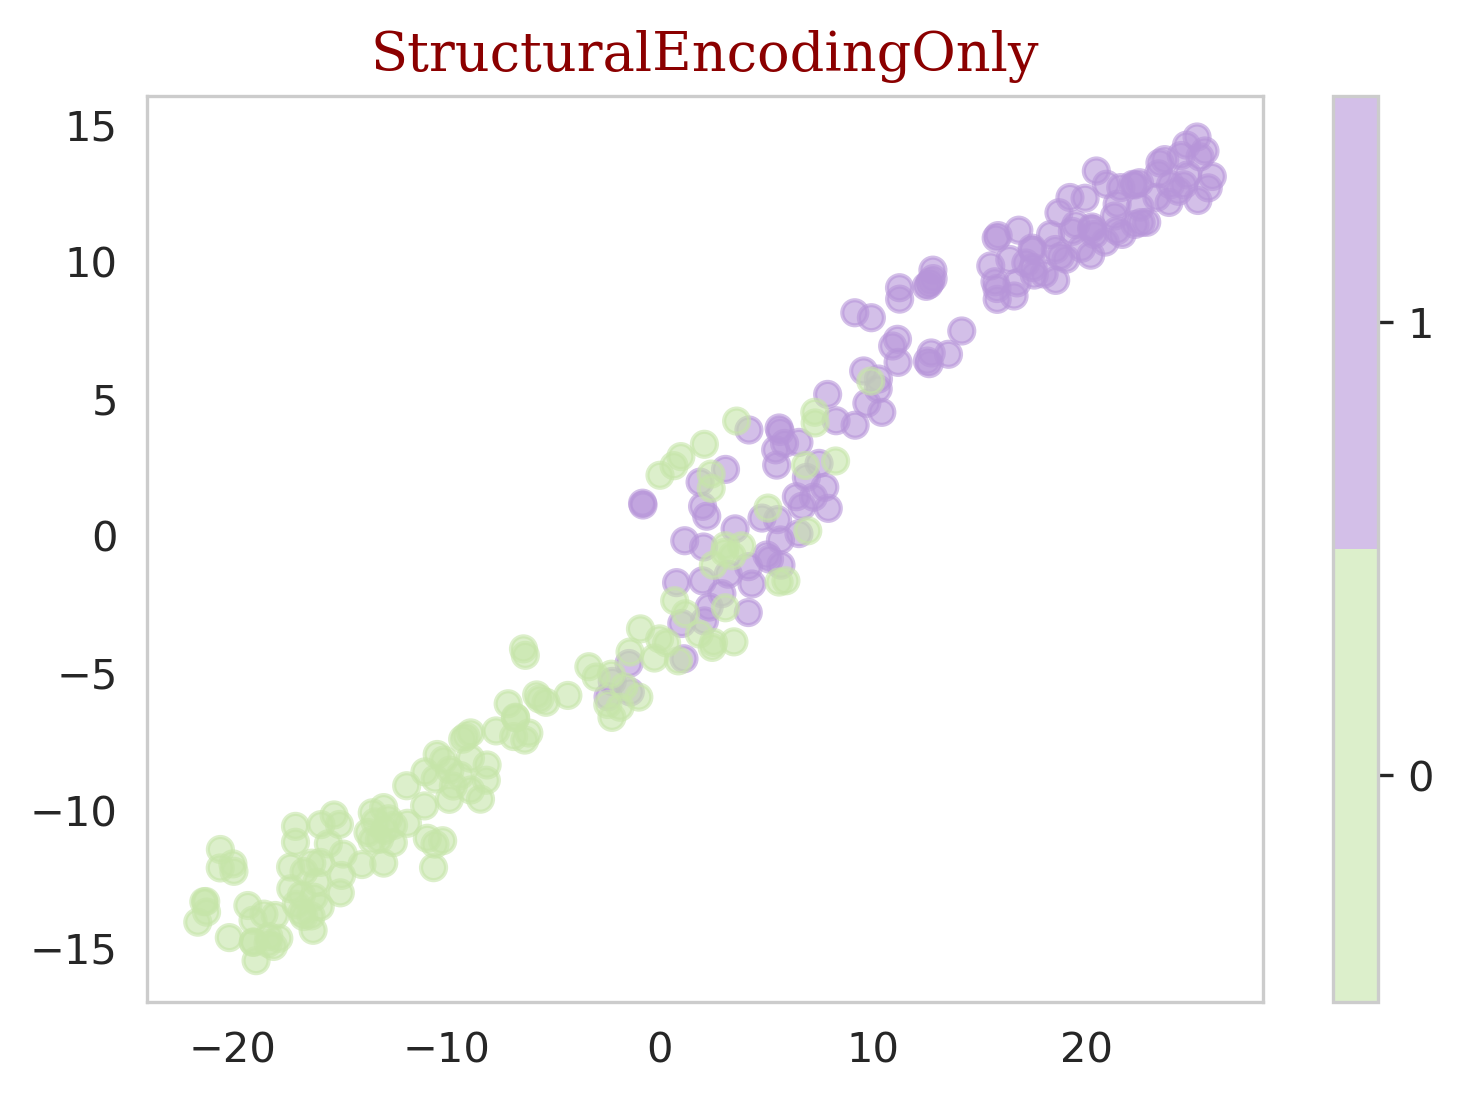

In [29]:
visualize_t_SNE("StructuralEncodingOnly", StructuralEncodingOnly_embedding, labels, 2)

/home/weilab/anaconda3/envs/jjr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/weilab/anaconda3/envs/jjr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<Figure size 1800x1200 with 0 Axes>

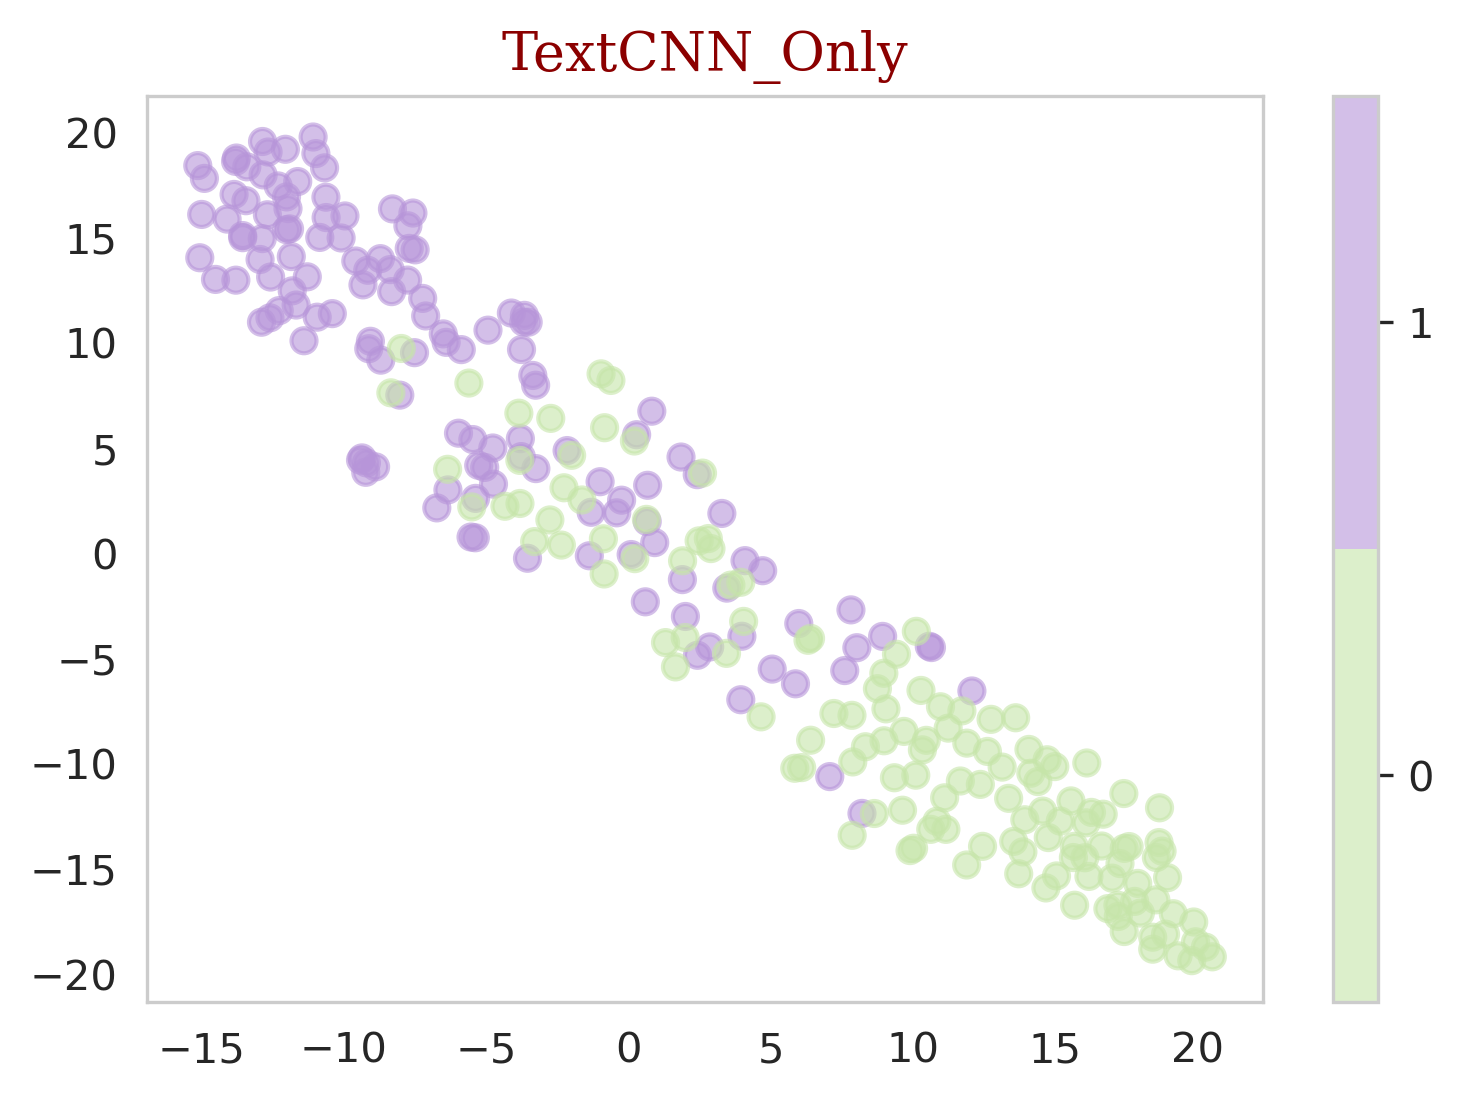

In [30]:
visualize_t_SNE("TextCNN_Only", TextCNN_Only_embedding, labels, 2)

<Figure size 1800x1200 with 0 Axes>

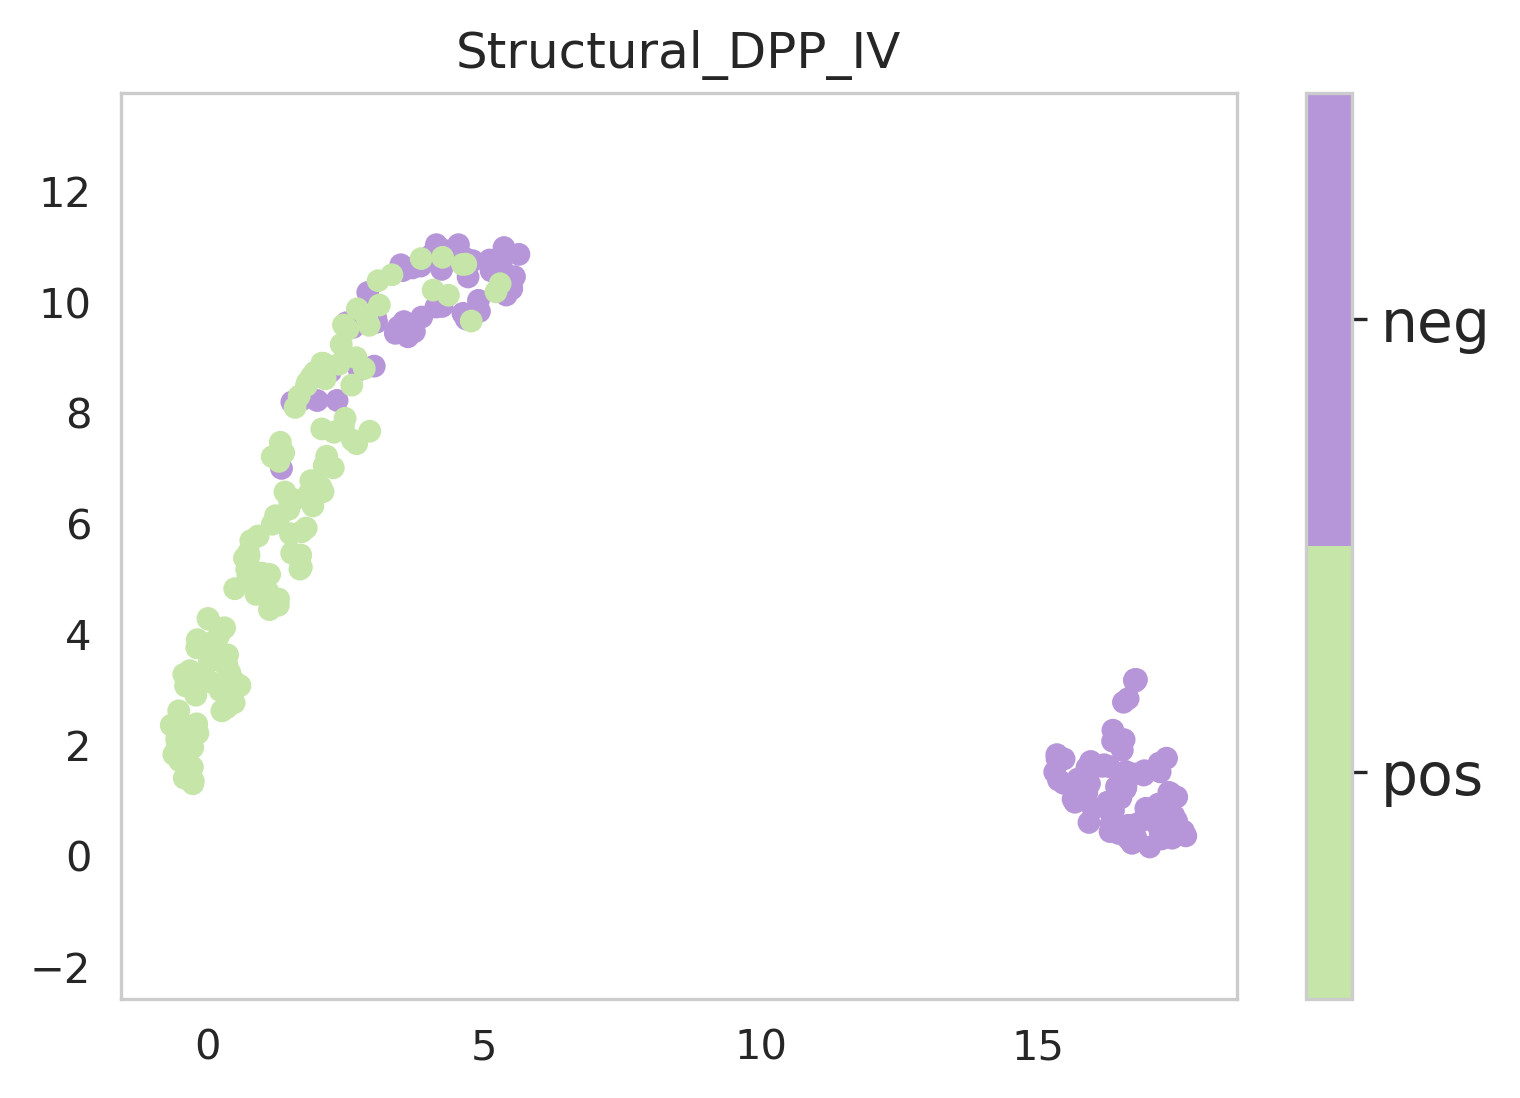

In [35]:
visualize_Umap("Structural_DPP_IV", Structural_DPP_IV_embedding, labels, 2)

<Figure size 1800x1200 with 0 Axes>

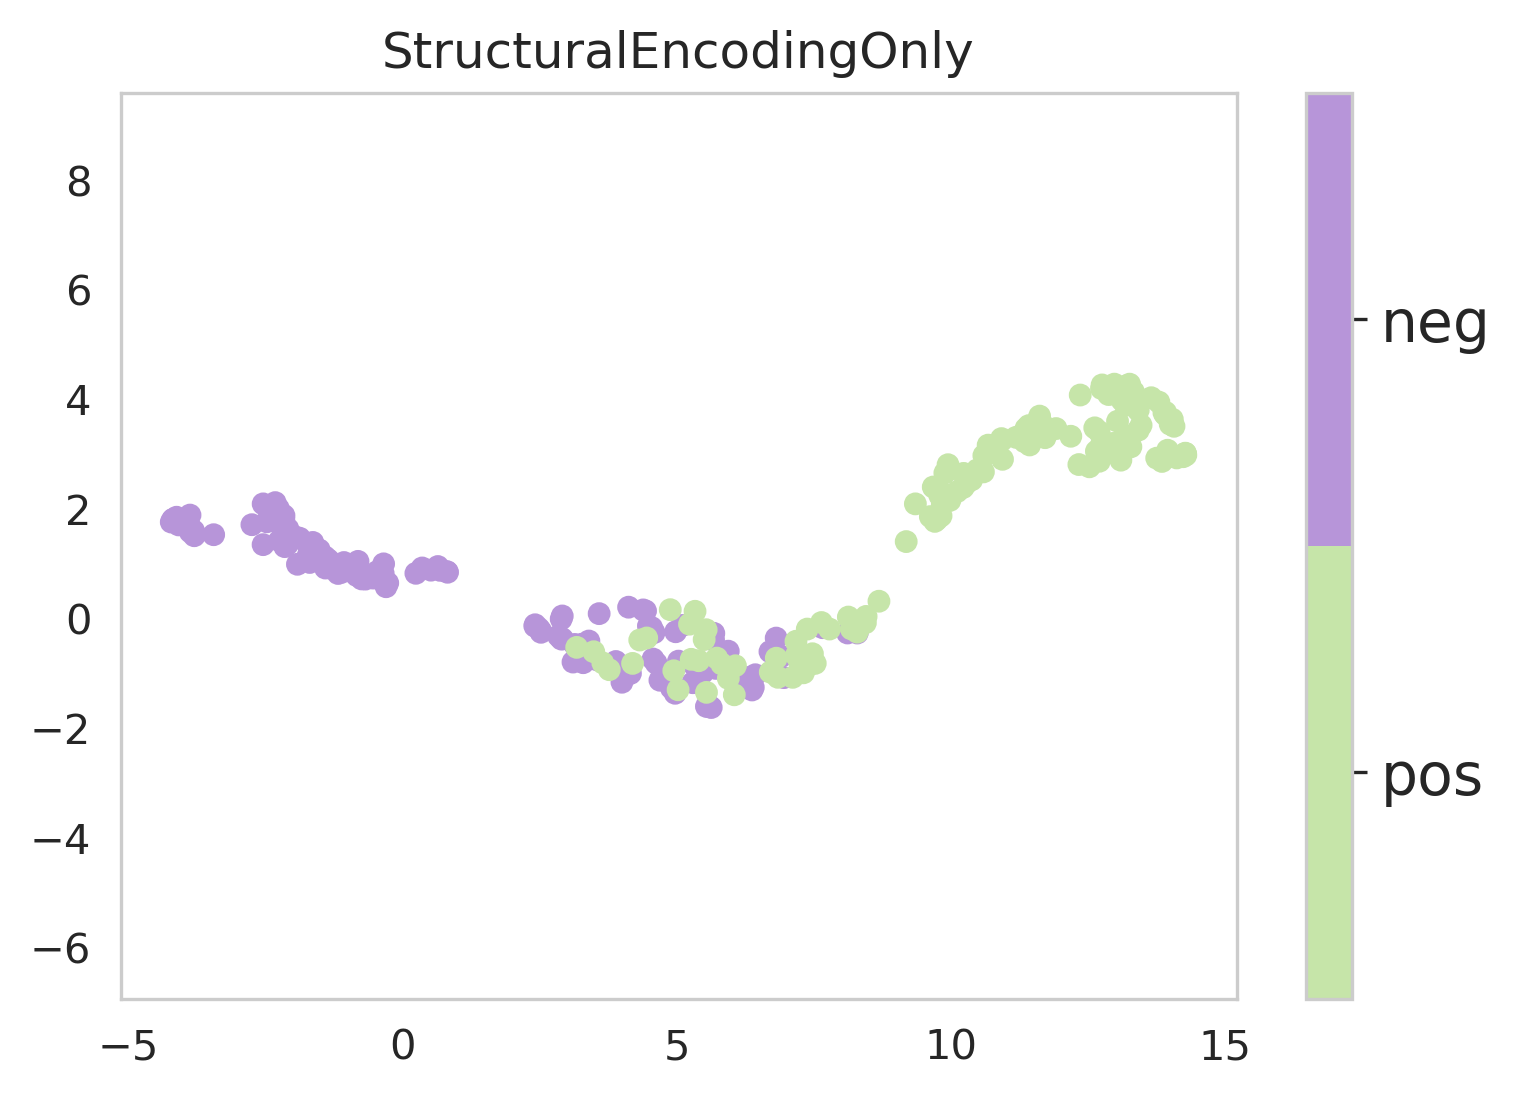

In [43]:
visualize_Umap("StructuralEncodingOnly", StructuralEncodingOnly_embedding, labels, 2)

<Figure size 1800x1200 with 0 Axes>

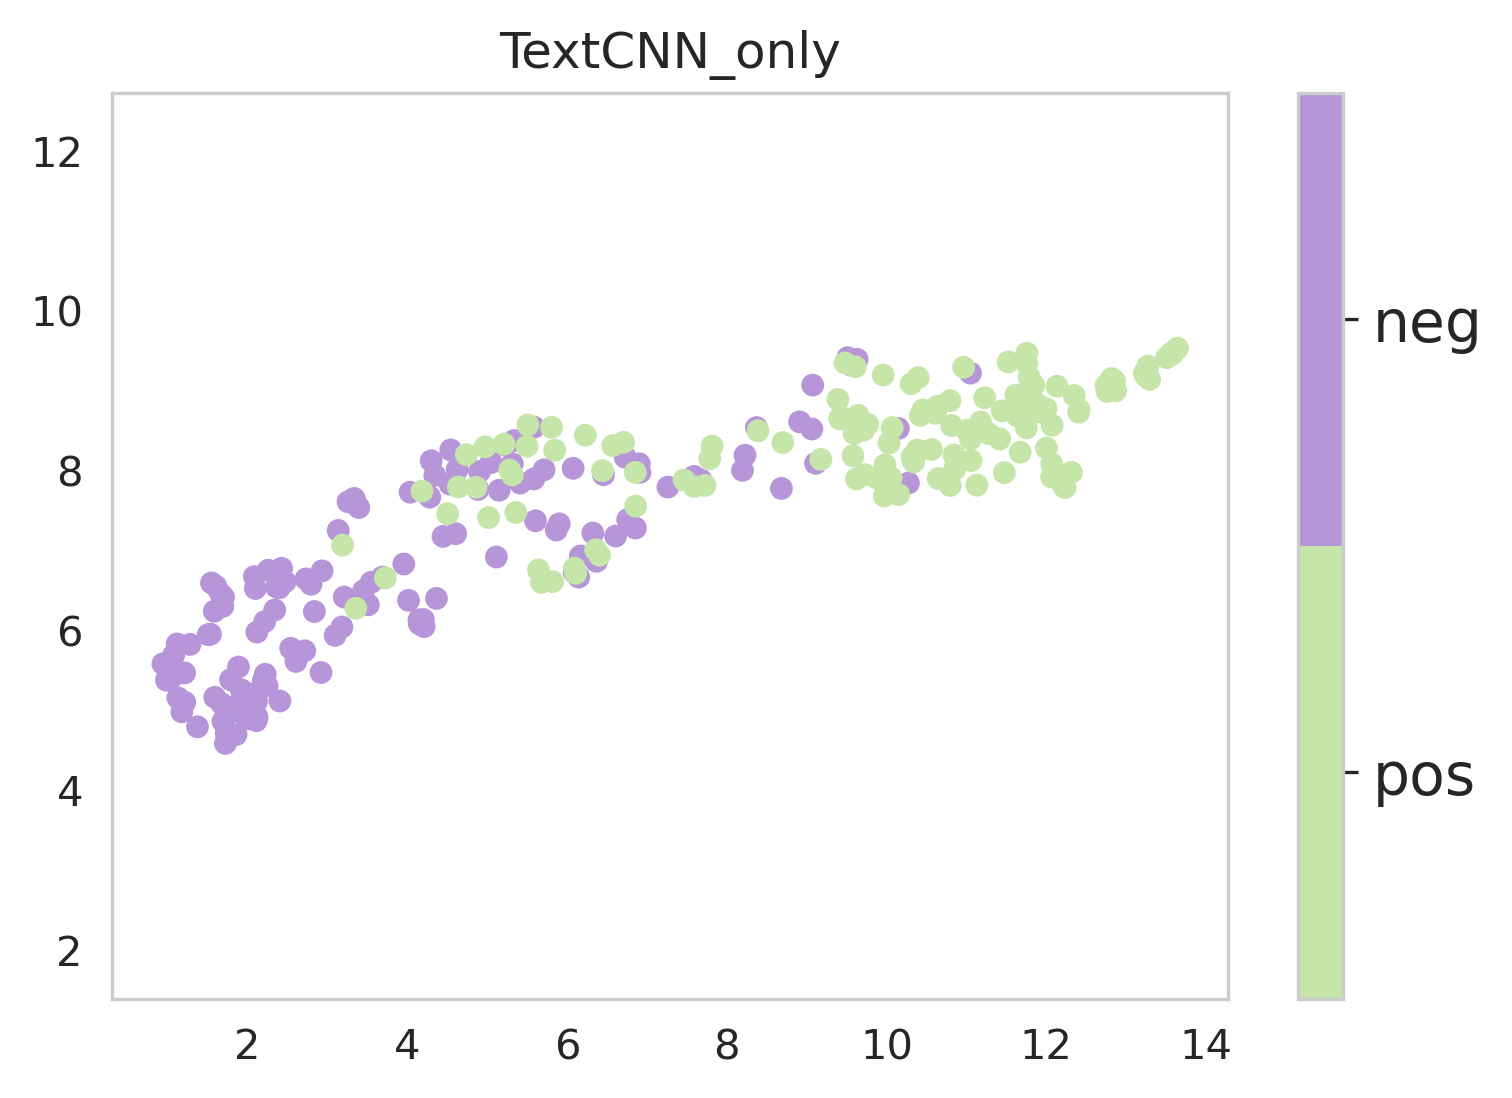

In [41]:
visualize_Umap("TextCNN_only", TextCNN_Only_embedding, labels, 2)